<a href="https://colab.research.google.com/github/multiopti/MYWAI/blob/main/hailstoneTFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
!{sys.executable} -m pip install pytorch_forecasting
pd.options.mode.chained_assignment = None  # default='warn'
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import NBeats
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting.models.deepar import DeepAR
from pytorch_forecasting.utils import profile
from matplotlib import pyplot as plt
#warnings.simplefilter("error", category=SettingWithCopyWarning)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
def hailstone(n):
    if (n > 1):
        if (n % 2 == 0):
            n = n / 2
        else:
            n = 3 * n + 1
    return n

def hailstone_series(m):
    S = np.empty([1,3])
    for i in range(m):
        j = i
        ind = 0
        while (j > 1)&(j < 200):
            S = np.append(S, np.array([[i - 2, ind, j]]), axis=0)
            j = hailstone(j)
            ind = ind + 1
    S = np.delete(S,0,axis = 0)
    S = np.delete(S, 0, axis=0)
    return S


      series  time_idx  value
0          1         0    3.0
1          1         1   10.0
2          1         2    5.0
3          1         3   16.0
4          1         4    8.0
...      ...       ...    ...
1721     194        25    2.0
1722     195         0  197.0
1723     196         0  198.0
1724     196         1   99.0
1725     197         0  199.0

[1726 rows x 3 columns]


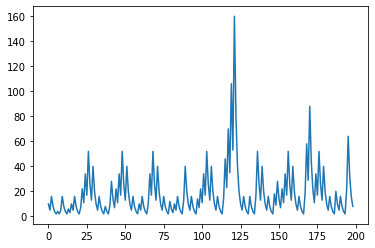

In [19]:
datahail = hailstone_series(300)
data = pd.DataFrame(datahail, columns=['series', 'time_idx', 'value'])
data['time_idx'] = data['time_idx'].astype(int)
data['value'] = data['value'].astype(float)
data['series'] = data['series'].astype(int)
print(data)
plt.plot(datahail[1:200,2])
plt.show()

max_encoder_length = 10
max_prediction_length = 5

training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    min_encoder_length=max_encoder_length //2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=GroupNormalizer(
        groups=["series"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_target_scales=True,
    add_encoder_length=True,
)

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True)




In [20]:
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=True, batch_size=batch_size, num_workers=0)

In [21]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

12.381250381469727

In [22]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=5,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7, 
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 17.2k


In [23]:
torch.set_num_threads(10)
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# calcualte mean absolute error on validation set
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
print(f"Mean absolute error of model: {(actuals - predictions).abs().mean()}")


INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 528   
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 6.490


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.911 >= min_delta = 0.0001. New best score: 4.579


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0001. New best score: 4.537


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.294 >= min_delta = 0.0001. New best score: 4.244


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.157 >= min_delta = 0.0001. New best score: 4.087


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.475 >= min_delta = 0.0001. New best score: 3.612


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.066 >= min_delta = 0.0001. New best score: 3.546


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.043 >= min_delta = 0.0001. New best score: 3.503


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.209 >= min_delta = 0.0001. New best score: 3.294


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.443 >= min_delta = 0.0001. New best score: 2.852


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.435 >= min_delta = 0.0001. New best score: 2.417


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 2.411


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.046 >= min_delta = 0.0001. New best score: 2.365


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 2.333


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.592 >= min_delta = 0.0001. New best score: 1.741


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.233 >= min_delta = 0.0001. New best score: 1.508


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.208 >= min_delta = 0.0001. New best score: 1.300
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Mean absolute error of model: 6.333498954772949


In [24]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

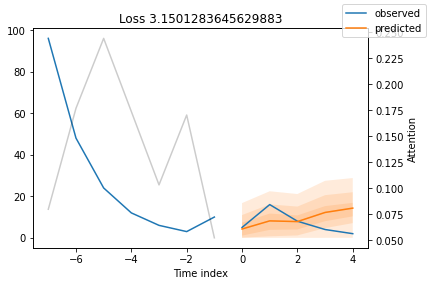

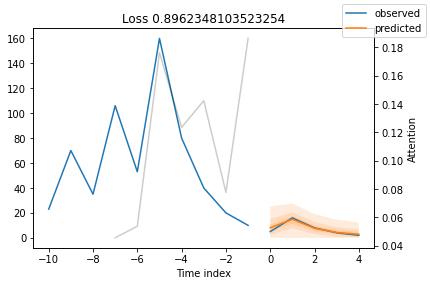

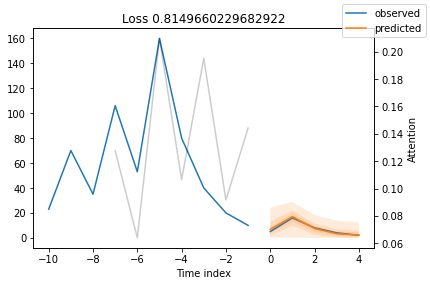

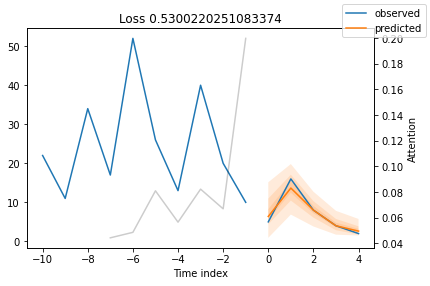

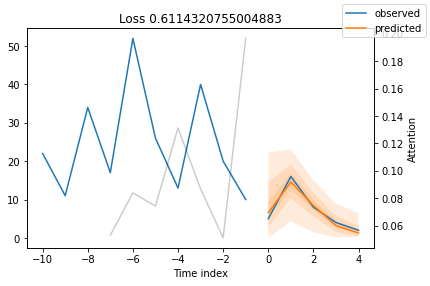

In [25]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(5):  
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);